# Tokenizing

In [1]:
import os
os.chdir(r"/Users/xinyuchen/OneDrive - Georgia Institute of Technology/Gatech/Courses/CS7641ML/Project/Preprocessing and Tokenizing/data")

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

In [2]:
## read data
train = pd.read_csv("news_classification_train.csv")
validation = pd.read_csv("news_classification_test.csv")

ticklabels = sorted(train["category"].unique().tolist())

In [3]:
### tr_y is the label for training data, val_y_true is the true label for validation data
tr_y = train["labels"]
val_y_true = validation["labels"]

In [31]:
### Method 3: Use Word Embedding Method
vocab_size = 25000
max_length = 50
trunc_type ='post'
padding_type ='post'
oov_tok = "<OOV>"

# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train["head_short"])
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
tr_embed = tokenizer.texts_to_sequences(train["head_short"])
tr_embed = pad_sequences(tr_embed,maxlen= max_length,
                         padding=padding_type, 
                         truncating=trunc_type)
tr_y = np.asarray(train["labels"])
tr_y = pd.get_dummies(tr_y)

# convert validation dataset to sequence and pad sequences
val_embed = tokenizer.texts_to_sequences(validation["head_short"])
val_embed = pad_sequences(val_embed,
                          maxlen = max_length,
                          padding = padding_type, 
                          truncating=trunc_type)
val_y = np.asarray(validation["labels"])
val_y = pd.get_dummies(val_y)

In [32]:
## create embedding matrix
### !wget http://nlp.stanford.edu/data/glove.6B.zip 
### !unzip -q glove.6B.zip 
glove_file =  'glove.6B.100d.txt'

num_tokens = len(word_index.items()) + 1
embedding_dim = 100
hits = 0
misses = 0

embeddings_index = {}
with open(glove_file, encoding = "utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(len(word_index)+1,embedding_dim,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable = False)

Converted 56752 words (29096 misses)


# CNN for Head_Short

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, backend, models, optimizers
from numpy.random import seed

seeds = 100
seed(seeds)
tf.random.set_seed(seeds)

In [7]:
# Explore the data
print(tr_embed.shape)

print(embedding_matrix.shape)


(144912, 50)

(85849, 100)


In [6]:
# Creat F1 function

def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(
        backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())

    return recall


def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(
        backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(
        backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())

    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*(precision*recall)/(precision+recall+backend.epsilon())

    return f1

In [86]:
# TextCNN

inp = layers.Input(shape=(max_length,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 5]:
    conv = layers.Conv1D(128, kernel_size, padding='same', activation='relu', strides=1,
                         kernel_initializer=initializers.he_normal(seed=seeds))(embedding)
    pool = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(conv)
    noise = layers.GaussianDropout(0.5)(pool)
    stacks.append(noise)

merged = layers.Concatenate()(stacks)
flatten = layers.Flatten()(merged)
drop = layers.Dropout(0.3)(flatten)
dense = layers.Dense(128, activation='relu')(drop)
out = layers.Dense(tr_y.shape[1], activation='softmax')(dense)

TextCNN = models.Model(inputs=inp, outputs=out)
adam=optimizers.Adam(learning_rate=1)
TextCNN.compile(loss='mse',
                optimizer='adam',
                metrics=['accuracy', f1_m])

# Model summary
print(TextCNN.summary())

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 100)      8584900     input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_84 (Conv1D)              (None, 50, 128)      25728       embedding_4[23][0]               
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 50, 128)      38528       embedding_4[23][0]               
___________________________________________________________________________________________

In [ ]:
# Model initialization
model = tf.keras.Sequential([layers.Input(shape=(max_length), dtype='int32'),
                             embedding_layer,
                             layers.Dropout(0.5),
                             layers.Conv1D(128, 3, padding='same', activation='relu',
                                           kernel_initializer=initializers.glorot_normal(seed=seeds)),
                             layers.Conv1D(128, 5, padding='same', activation='relu',
                                           kernel_initializer=initializers.glorot_normal(seed=seeds)),
                             layers.MaxPooling1D(
                                 pool_size=1, strides=None, padding='same'),
                             layers.Conv1D(128, 5, padding='same', activation='relu',
                                           kernel_initializer=initializers.glorot_normal(seed=seeds)),
                             layers.Conv1D(128, 5, padding='same', activation='relu',
                                           kernel_initializer=initializers.glorot_normal(seed=seeds)),
                             layers.MaxPooling1D(
                                 pool_size=1, strides=None, padding='same'),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(28, activation='softmax')
                             ])

# Compile model
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy', f1_m])

# Model summary
print(model.summary())

In [87]:
# Fit model
num_epochs = 30
history = TextCNN.fit(tr_embed, tr_y,
                    batch_size = 128,
                    epochs = num_epochs, verbose = 2, shuffle = False,
                    validation_split = 0.3)

Epoch 1/30
793/793 - 40s - loss: 0.0268 - accuracy: 0.4032 - f1_m: 0.3558 - val_loss: 0.0225 - val_accuracy: 0.5208 - val_f1_m: 0.4984
Epoch 2/30
793/793 - 37s - loss: 0.0213 - accuracy: 0.5570 - f1_m: 0.5385 - val_loss: 0.0195 - val_accuracy: 0.6039 - val_f1_m: 0.5798
Epoch 3/30
793/793 - 38s - loss: 0.0193 - accuracy: 0.6048 - f1_m: 0.5925 - val_loss: 0.0191 - val_accuracy: 0.6140 - val_f1_m: 0.5971
Epoch 4/30
793/793 - 39s - loss: 0.0186 - accuracy: 0.6250 - f1_m: 0.6162 - val_loss: 0.0189 - val_accuracy: 0.6209 - val_f1_m: 0.6087
Epoch 5/30
793/793 - 40s - loss: 0.0180 - accuracy: 0.6380 - f1_m: 0.6325 - val_loss: 0.0188 - val_accuracy: 0.6211 - val_f1_m: 0.6109
Epoch 6/30
793/793 - 40s - loss: 0.0176 - accuracy: 0.6488 - f1_m: 0.6457 - val_loss: 0.0187 - val_accuracy: 0.6247 - val_f1_m: 0.6144
Epoch 7/30
793/793 - 39s - loss: 0.0172 - accuracy: 0.6568 - f1_m: 0.6560 - val_loss: 0.0188 - val_accuracy: 0.6242 - val_f1_m: 0.6167
Epoch 8/30
793/793 - 38s - loss: 0.0169 - accuracy: 0.6

In [68]:
# Predict values for the test set

pred = TextCNN.predict(val_embed, verbose = 1)

1133/1133 [==============================] - 5s 4ms/step


In [69]:
# Evaluate the model in test set

TextCNN.evaluate(val_embed, val_y)

1133/1133 [==============================] - 5s 4ms/step - loss: 0.0192 - accuracy: 0.6301 - f1_m: 0.6330


[0.019153259694576263, 0.6301203370094299, 0.6330426335334778]

# CNN for Head

In [97]:
### Method 3: Use Word Embedding Method
vocab_size = 25000
max_length = 50
trunc_type ='post'
padding_type ='post'
oov_tok = "<OOV>"

Train_Headline = train['headline_new'].astype("str")
Test_Headline = validation['headline_new'].astype("str")

# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(Train_Headline)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
tr_embed = tokenizer.texts_to_sequences(Train_Headline)
tr_embed = pad_sequences(tr_embed,maxlen= max_length,
                         padding=padding_type, 
                         truncating=trunc_type)
tr_y = np.asarray(train["labels"])
tr_y = pd.get_dummies(tr_y)

# convert validation dataset to sequence and pad sequences
val_embed = tokenizer.texts_to_sequences(Test_Headline)
val_embed = pad_sequences(val_embed,
                          maxlen = max_length,
                          padding = padding_type, 
                          truncating=trunc_type)
val_y = np.asarray(validation["labels"])
val_y = pd.get_dummies(val_y)

In [98]:
## create embedding matrix
### !wget http://nlp.stanford.edu/data/glove.6B.zip 
### !unzip -q glove.6B.zip 
glove_file =  'glove.6B.100d.txt'

num_tokens = len(word_index.items()) + 1
embedding_dim = 100
hits = 0
misses = 0

embeddings_index = {}
with open(glove_file, encoding = "utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(len(word_index)+1,embedding_dim,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable = False)

Converted 37554 words (12271 misses)


In [99]:
# Fit model
num_epochs = 50
history = TextCNN.fit(tr_embed, tr_y,
                    batch_size = 128,
                    epochs = num_epochs, verbose = 2, shuffle = False,
                    validation_split = 0.3)

Epoch 1/50
793/793 - 40s - loss: 0.0323 - accuracy: 0.1873 - f1_m: 0.0799 - val_loss: 0.0311 - val_accuracy: 0.2367 - val_f1_m: 0.1089
Epoch 2/50
793/793 - 37s - loss: 0.0312 - accuracy: 0.2346 - f1_m: 0.1289 - val_loss: 0.0305 - val_accuracy: 0.2678 - val_f1_m: 0.1388
Epoch 3/50
793/793 - 38s - loss: 0.0305 - accuracy: 0.2687 - f1_m: 0.1639 - val_loss: 0.0295 - val_accuracy: 0.3026 - val_f1_m: 0.1870
Epoch 4/50
793/793 - 37s - loss: 0.0296 - accuracy: 0.3025 - f1_m: 0.2166 - val_loss: 0.0288 - val_accuracy: 0.3219 - val_f1_m: 0.2333
Epoch 5/50
793/793 - 37s - loss: 0.0290 - accuracy: 0.3212 - f1_m: 0.2459 - val_loss: 0.0284 - val_accuracy: 0.3420 - val_f1_m: 0.2412
Epoch 6/50
793/793 - 36s - loss: 0.0285 - accuracy: 0.3364 - f1_m: 0.2724 - val_loss: 0.0280 - val_accuracy: 0.3523 - val_f1_m: 0.2635
Epoch 7/50
793/793 - 37s - loss: 0.0281 - accuracy: 0.3450 - f1_m: 0.2909 - val_loss: 0.0277 - val_accuracy: 0.3555 - val_f1_m: 0.2787
Epoch 8/50
793/793 - 37s - loss: 0.0278 - accuracy: 0.3

# CNN for Short

In [91]:
### Method 3: Use Word Embedding Method
vocab_size = 25000
max_length = 50
trunc_type ='post'
padding_type ='post'
oov_tok = "<OOV>"

Train_Headline = train['short_description_new'].astype("str")
Test_Headline = validation['short_description_new'].astype("str")

# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(Train_Headline)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
tr_embed = tokenizer.texts_to_sequences(Train_Headline)
tr_embed = pad_sequences(tr_embed,maxlen= max_length,
                         padding=padding_type, 
                         truncating=trunc_type)
tr_y = np.asarray(train["labels"])
tr_y = pd.get_dummies(tr_y)

# convert validation dataset to sequence and pad sequences
val_embed = tokenizer.texts_to_sequences(Test_Headline)
val_embed = pad_sequences(val_embed,
                          maxlen = max_length,
                          padding = padding_type, 
                          truncating=trunc_type)
val_y = np.asarray(validation["labels"])
val_y = pd.get_dummies(val_y)

In [92]:
## create embedding matrix
### !wget http://nlp.stanford.edu/data/glove.6B.zip 
### !unzip -q glove.6B.zip 
glove_file =  'glove.6B.100d.txt'

num_tokens = len(word_index.items()) + 1
embedding_dim = 100
hits = 0
misses = 0

embeddings_index = {}
with open(glove_file, encoding = "utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(len(word_index)+1,embedding_dim,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable = False)

Converted 50473 words (21081 misses)


In [96]:
# Fit model
num_epochs = 60
history = TextCNN.fit(tr_embed, tr_y,
                    batch_size = 128,
                    epochs = num_epochs, verbose = 2, shuffle = False,
                    validation_split = 0.3)

Epoch 1/5
793/793 - 41s - loss: 0.0283 - accuracy: 0.3344 - f1_m: 0.2808 - val_loss: 0.0298 - val_accuracy: 0.2980 - val_f1_m: 0.1860
Epoch 2/5
793/793 - 38s - loss: 0.0283 - accuracy: 0.3349 - f1_m: 0.2829 - val_loss: 0.0298 - val_accuracy: 0.2972 - val_f1_m: 0.1983
Epoch 3/5
793/793 - 39s - loss: 0.0283 - accuracy: 0.3365 - f1_m: 0.2831 - val_loss: 0.0298 - val_accuracy: 0.2983 - val_f1_m: 0.1936
Epoch 4/5
793/793 - 39s - loss: 0.0283 - accuracy: 0.3358 - f1_m: 0.2843 - val_loss: 0.0298 - val_accuracy: 0.3001 - val_f1_m: 0.2001
Epoch 5/5
793/793 - 37s - loss: 0.0283 - accuracy: 0.3366 - f1_m: 0.2854 - val_loss: 0.0299 - val_accuracy: 0.2973 - val_f1_m: 0.1850


# Utility function

In [19]:
# Plot model accuracy and loss

def plot_history(history):
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Training Accuracy', \
             c = 'blue', lw = '2')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', \
             c = 'red', lw = '2')
    plt.title('Accuracy', loc = 'left', fontsize = 16)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Training Loss', \
             c = 'blue', lw = '2')
    plt.plot(history.history['val_loss'], label = 'Validation Loss', \
             c = 'red', lw = '2')
    plt.title('Loss', loc = 'left', fontsize = 16)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

In [20]:
# Plot confusion matrix

def plot_confusion_matrix(val_labels, pred_labels, ticklabels):
    fig, ax = plt.subplots(figsize = (10, 8))
    
    cm = confusion_matrix(val_labels, pred_labels)
    
    sns.heatmap(cm, annot = False, cbar = True,
                cmap = 'Blues', ax = ax)
    ax.set_xlabel('Predicted News Class')
    ax.set_ylabel('Actual News Class')
    ax.set_xticklabels(ticklabels, rotation = 90)
    ax.set_yticklabels(ticklabels, rotation = 0)
    
    plt.show()
    

# Evaluation

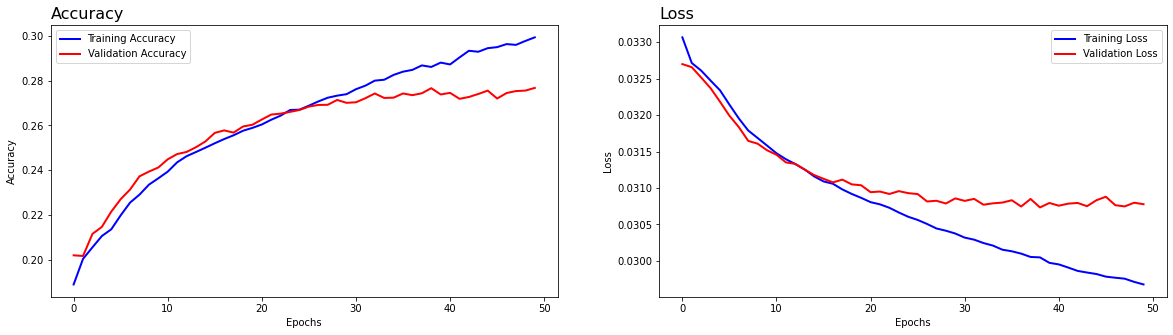

In [21]:
# plot history

plot_history(history)

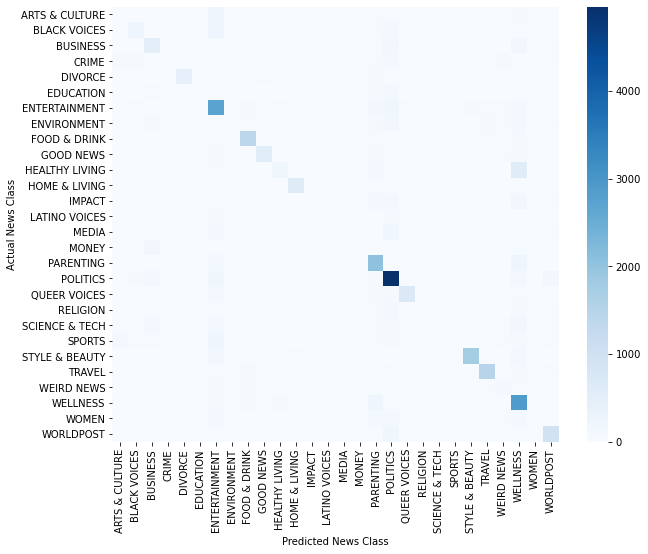

In [22]:
# plot confusion matrix

pred_vec = np.array([np.argmax(i) for i in pred])
plot_confusion_matrix(val_y_true, pred_vec, ticklabels) 